# Download Dataset

In [36]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("maestroalert/pneumonia")

# print("Path to dataset files:", path)

100%|██████████| 2.76G/2.76G [01:22<00:00, 35.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/maestroalert/pneumonia/versions/1


# Import libraries

In [19]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
import imutils
import scipy


# Data Visualisation


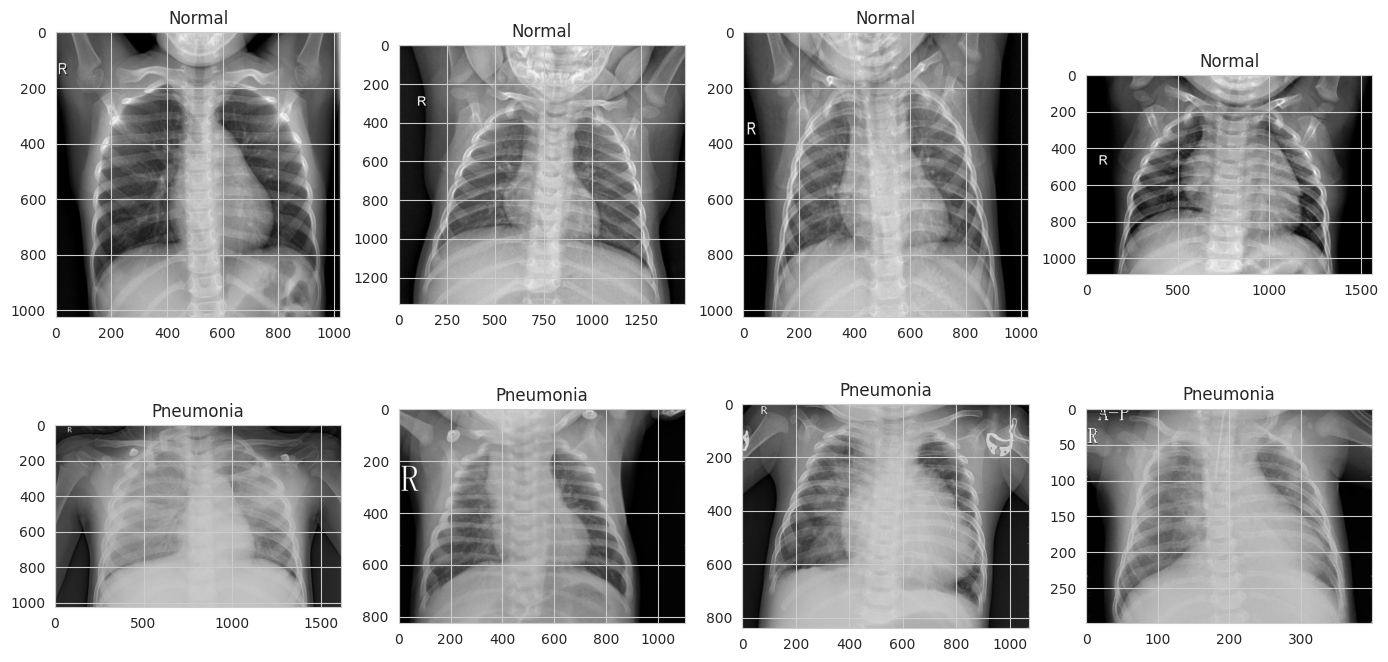

In [38]:
train_dir = "/workspace/xray/xray/train/"
test_dir = "/workspace/xray/xray/test/"

classes = os.listdir("/workspace/xray/xray/train/")

files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range (1,5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)



# Image Preprocessing And From Directory

In [40]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_data = datagen.flow_from_directory('/workspace/xray/xray/train', target_size=(224,224), batch_size=32, class_mode='binary')

valid_data = datagen.flow_from_directory('/workspace/xray/xray/val', target_size=(224,224), batch_size=32, class_mode='binary')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/workspace/xray/xray/test', target_size=(224,224), class_mode='binary')


Found 7063 images belonging to 2 classes.
Found 432 images belonging to 2 classes.
Found 432 images belonging to 2 classes.


In [41]:
print(train_data.class_indices)
print(test_data.class_indices)

{'Normal': 0, 'Pneumonia': 1}
{'Normal': 0, 'Pneumonia': 1}


# Build The Model

In [42]:
# Build the Model

resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224, 3))

model = resnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(1, activation="sigmoid")(model)
model = Model(inputs= resnet.input, outputs=model)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

# Compile The Model

In [43]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
import datetime # TensorBoard için

# Modelin zaten tanımlanmış ve oluşturulmuş olduğunu varsayıyoruz (ResNet50)
# model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# model = add_top_layers(model, num_classes) # Kendi eklediğin üst katmanlar

# --- Optimize Edilmiş Compile Ayarları ---

# AdamW için öğrenme oranı ve ağırlık bozunması (weight_decay) başlangıç değerleri
# ResNet50 gibi derin modeller için başlangıç öğrenme oranı genellikle biraz daha yüksek olabilir.
# Ağırlık bozunması, aşırı öğrenmeyi (overfitting) engellemek için önemlidir.
initial_learning_rate = 1e-4 # Genellikle 1e-4 veya 5e-5 ile başlanır
weight_decay_rate = 1e-5    # 1e-5 ile 1e-4 arası deneyin, modelinize göre ayarlanabilir

model.compile(
    optimizer=AdamW(learning_rate=initial_learning_rate, weight_decay=weight_decay_rate),
    loss='binary_crossentropy', # Zatürre ikili sınıflandırma için uygun
    metrics=['accuracy', 'Precision', 'Recall', 'AUC'] # Daha kapsamlı metrikler ekleyebiliriz
)

print(f"Model optimize ediliyor: Learning Rate={initial_learning_rate}, Weight Decay={weight_decay_rate}")

# --- Optimize Edilmiş Callbacks (Geri Çağrılar) ---

# 1. ReduceLROnPlateau (Öğrenme Oranını Azaltma)
# val_loss'u izlemek yerine val_accuracy'yi izlemek daha mantıklı olabilir,
# çünkü amacımız doğruluk oranını artırmak. Factor ve patience değerleri modelinize göre ayarlanır.
# Çok hızlı düşürmemek için patience'ı biraz artırabiliriz.
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', # val_loss yerine val_accuracy'yi takip et
    mode='max',             # val_accuracy'nin artmasını bekliyoruz
    factor=0.2,             # Öğrenme oranını 0.3 yerine 0.2 ile çarp (daha büyük düşüş)
    patience=5,             # 3 yerine 5 epoch bekle (daha sabırlı)
    verbose=1,
    min_lr=1e-7             # Minimum öğrenme oranını biraz daha düşürebiliriz
)
print(f"ReduceLROnPlateau ayarlandı: Monitor='val_accuracy', Patience={reduce_lr.patience}, Factor={reduce_lr.factor}")


# 2. ModelCheckpoint (Model Kaydetme)
# Val_accuracy'yi izlemek iyi, ancak model.h5 yerine epoch ve accuracy bilgilerini içeren bir isim kullanmak
# farklı denemeleri ayırt etmenizi sağlar. Ayrıca save_weights_only=True de daha hafif dosyalar sağlar.
checkpoint = ModelCheckpoint(
    "resnet50_best_model_{epoch:02d}_{val_accuracy:.4f}.h5", # Model adı dinamik olsun
    monitor="val_accuracy",
    save_best_only=True,
    mode="max", # val_accuracy'nin maksimum değerini kaydet
    verbose=1
)
print(f"ModelCheckpoint ayarlandı: Monitor='val_accuracy', Kayıt formatı='resnet50_best_model_XX_YY.h5'")


# 3. EarlyStopping (Erken Durdurma)
# Aşırı öğrenmeyi engellemek ve zamandan tasarruf etmek için önemli. Patience'ı biraz artırmak iyi olabilir.
earlystop = EarlyStopping(
    monitor="val_accuracy",
    patience=8,             # 5 yerine 8 epoch bekle (daha sabırlı, reduce_lr'den biraz daha fazla)
    mode="max",             # val_accuracy'nin artmasını bekliyoruz
    verbose=1,
    restore_best_weights=True # En iyi ağırlıkları geri yükle
)
print(f"EarlyStopping ayarlandı: Monitor='val_accuracy', Patience={earlystop.patience}")


# 4. TensorBoard (Eklemek İstediğim Yeni Callback)
# Eğitim sürecini görselleştirmek, kayıp ve doğruluk grafiklerini görmek, öğrenme oranını takip etmek
# ve hatta model grafiğini incelemek için harika bir araçtır.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) # histogram_freq = 1 ağırlık dağılımlarını gösterir.
print(f"TensorBoard ayarlandı: Log dizini='{log_dir}'")


# Tüm callback'leri bir listeye topluyoruz
callbacks_list = [checkpoint, earlystop, reduce_lr, tensorboard_callback]

# Modeli eğitirken bu callback'leri kullanın
# history = model.fit(train_data, epochs=20, batch_size=32,
#                     validation_data=valid_data, verbose=1,
#                     callbacks=callbacks_list)

Model optimize ediliyor: Learning Rate=0.0001, Weight Decay=1e-05
ReduceLROnPlateau ayarlandı: Monitor='val_accuracy', Patience=5, Factor=0.2
ModelCheckpoint ayarlandı: Monitor='val_accuracy', Kayıt formatı='resnet50_best_model_XX_YY.h5'
EarlyStopping ayarlandı: Monitor='val_accuracy', Patience=8
TensorBoard ayarlandı: Log dizini='logs/fit/20250611-094332'


# Fit The Model

In [44]:
history = model.fit(train_data, epochs=10, validation_data=valid_data, verbose=1, callbacks=callbacks_list)

Epoch 1/10
221/221 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9384 - precision: 0.9538 - recall: 0.9427 - auc: 0.9842
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to resnet50_best_model_01_0.5000.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


221/221 [==============================] - 197s 760ms/step - loss: 0.1567 - accuracy: 0.9384 - precision: 0.9538 - recall: 0.9427 - auc: 0.9842 - val_loss: 1.6162 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.3250 - lr: 1.0000e-04
Epoch 2/10
221/221 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9621 - precision: 0.9703 - recall: 0.9662 - auc: 0.9913
Epoch 2: val_accuracy did not improve from 0.50000
221/221 [==============================] - 144s 650ms/step - loss: 0.1080 - accuracy: 0.9621 - precision: 0.9703 - recall: 0.9662 - auc: 0.9913 - val_loss: 1.8577 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.1709 - lr: 1.0000e-04
Epoch 3/10
221/221 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9697 - precision: 0.9767 - recall: 0.9725 - auc: 0.9946
Epoch 3: val_accuracy improved from 0.50000 to 0.50231, saving model to resnet50_best_model_03_0.5023.h5
221/221 [=========

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Verileri DataFrame'e dönüştürmek için

def grafik_func(history):
    """
    Model eğitim geçmişindeki metrikleri Seaborn kullanarak daha modern bir şekilde çizer.
    Train ve Validation için belirgin renkler ve noktalı yapılar kullanır.
    Metrik yoksa grafik çizmez.

    Args:
        history: Keras'ın model.fit() metodundan dönen history nesnesi.
                 history.history dictionary'sini içermelidir.
    """
    # Seaborn stilini ayarla
    sns.set_style("whitegrid") # Beyaz ızgara arka planı

    # Manuel renk paleti oluştur (Train ve Validation için belirgin renkler)
    # Train için genellikle mavi tonları, Validation için turuncu/kırmızı tonları tercih edilir.
    colors = {
        'Train': 'blue',    # Koyu bir mavi
        'Validation': 'red' # Kırmızı, çok daha belirgin
    }

    # Metrik listesi: her biri için ayrı grafik çizilecek
    metric_pairs = [
        ("accuracy", "Accuracy"),
        ("loss", "Loss"),
        ("precision", "Precision"),
        ("recall", "Recall")
    ]

    for metric_name, display_name in metric_pairs:
        train_metric_key = metric_name
        val_metric_key = f"val_{metric_name}"

        # Metriklerin history objesinde olup olmadığını kontrol et
        if train_metric_key in history.history and val_metric_key in history.history:
            # Verileri DataFrame'e dönüştürerek Seaborn için uygun hale getir
            epochs = range(1, len(history.history[train_metric_key]) + 1)
            data = {
                'Epochs': list(epochs),
                'Value': history.history[train_metric_key] + history.history[val_metric_key],
                'Type': [f'Train {display_name}'] * len(epochs) + [f'Validation {display_name}'] * len(epochs)
            }
            df_train_val = pd.DataFrame({
                'Epochs': epochs,
                f'Train {display_name}': history.history[train_metric_key],
                f'Validation {display_name}': history.history[val_metric_key]
            })

            plt.figure(figsize=(10, 6)) # Grafik boyutunu ayarla

            # Seaborn lineplot kullanarak çizim yap
            # Her bir çizgi için farklı renk ve marker belirttik
            sns.lineplot(x='Epochs', y=f'Train {display_name}', data=df_train_val,
                         label=f'Train {display_name}', color=colors['Train'],
                         marker='o', markersize=6, linewidth=2) # 'o' daire marker, 's' kare, '^' üçgen
            sns.lineplot(x='Epochs', y=f'Validation {display_name}', data=df_train_val,
                         label=f'Validation {display_name}', color=colors['Validation'],
                         marker='X', markersize=7, linewidth=2) # 'X' çarpı marker

            plt.xlabel("Epochs", fontsize=12) # Etiket font boyutunu ayarla
            plt.ylabel(display_name, fontsize=12)
            plt.title(f"Model {display_name} Over Epochs", fontsize=14, fontweight='bold') # Başlık fontunu ayarla
            plt.legend(fontsize=10) # Lejant fontunu ayarla
            plt.grid(True, linestyle='--', alpha=0.7) # Izgarayı daha belirgin hale getir
            plt.tight_layout() # Düzenleme için boşlukları otomatik ayarla
            plt.show()
        else:
            print(f"⚠️ '{metric_name}' veya 'val_{metric_name}' bulunamadı, bu metrik için grafik çizilemedi.")

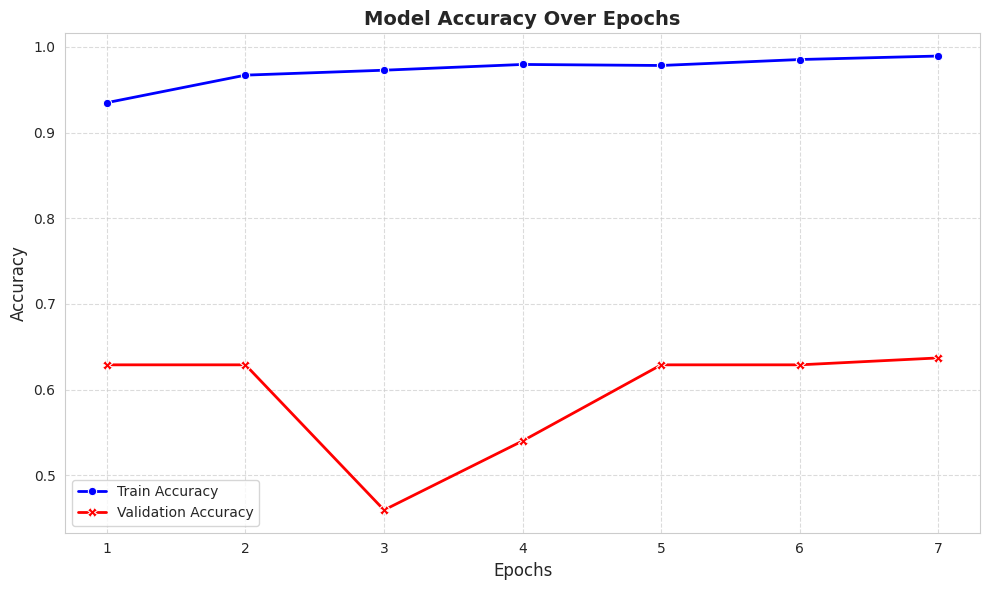

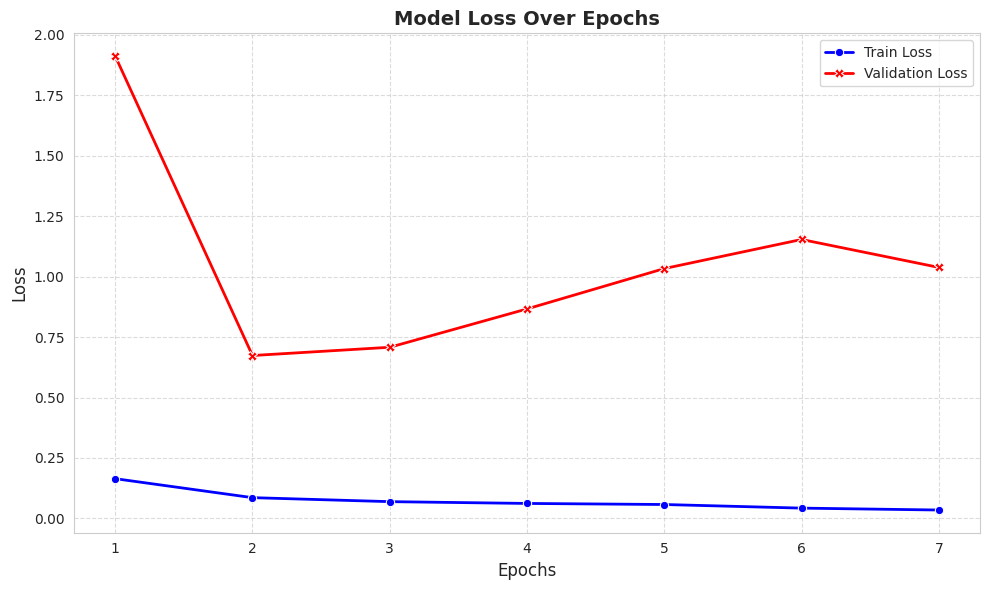

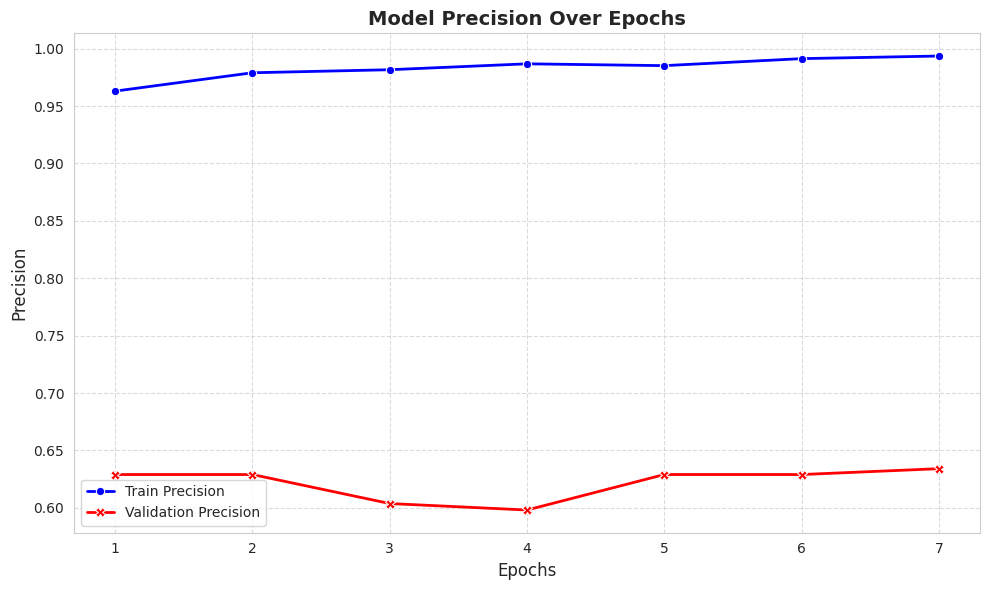

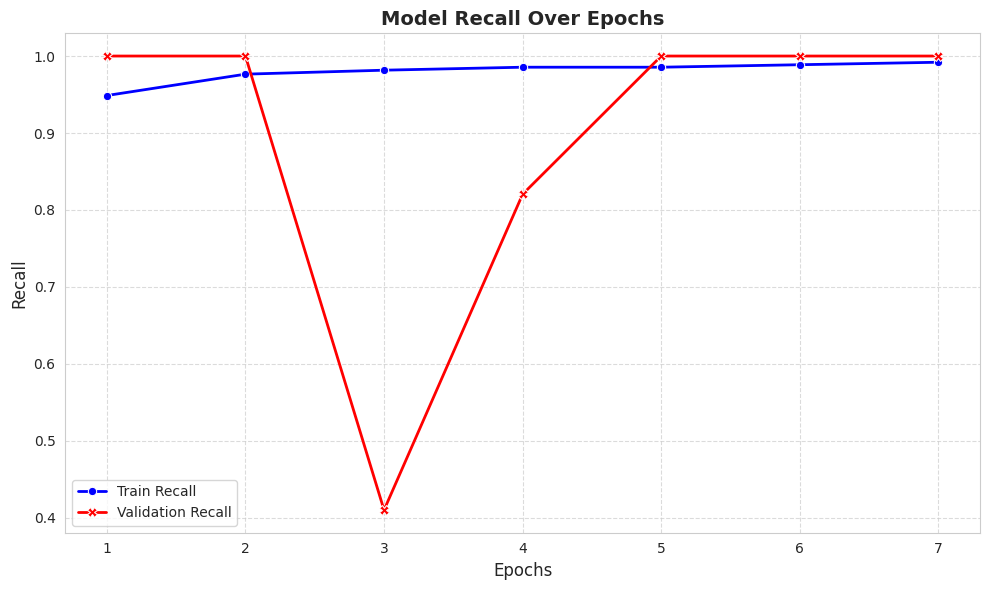

In [28]:
# Model eğitimini tamamladığında, history objesini elde ettiğin varsayılıyor
# history = model.fit(...)

grafik_func(history)

# PREDİCT BÖLÜMÜ

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


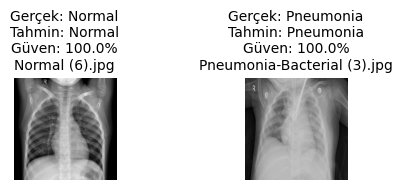

In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image, UnidentifiedImageError

# Sınıf isimleri ve indeksleri
class_names = ['Normal', 'Pneumonia']
class_indices = {'Normal': 0, 'Pneumonia': 1}

def get_random_image_per_class(data_dir):
    """Her sınıf klasöründen rastgele bir görsel seçer."""
    samples = []
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if not image_files:
            continue
        random_img = random.choice(image_files)
        full_path = os.path.join(class_dir, random_img)
        samples.append((full_path, class_indices[class_name]))
    return samples

def predict_and_visualize(samples, model_path):
    """Görselleri tahmin et ve yan yana göster."""
    model = load_model(model_path)

    plt.figure(figsize=(5, 2))
    for i, (img_path, true_class) in enumerate(samples):
        try:
            img = Image.open(img_path).convert("RGB")
            img_resized = img.resize((224, 224))
            img_array = np.array(img_resized) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            prediction = model.predict(img_array)
            # İkili sınıflandırma için sigmoid çıkışı
            predicted_class = int(prediction[0][0] > 0.5)
            confidence = prediction[0][0] * 100 if predicted_class == 1 else (1 - prediction[0][0]) * 100
            predicted_label = class_names[predicted_class]

            # Görselleştirme
            plt.subplot(1, len(samples), i + 1)
            plt.imshow(img_resized)
            plt.axis("off")
            plt.title(f"Gerçek: {class_names[true_class]}\nTahmin: {predicted_label}\nGüven: {confidence:.1f}%\n{os.path.basename(img_path)}",
                      fontsize=10)

        except UnidentifiedImageError:
            print(f"Hatalı görsel atlandı: {img_path}")
            continue

    plt.tight_layout()
    plt.show()

# Kullanım
data_dir = "C:\\Users\\Batu\\Documents\\MediAIn\\models\\tamamlandı\\resnet\\test\\"
model_path = "resnet50_best_model_09_0.9954.h5"

samples = get_random_image_per_class(data_dir)
predict_and_visualize(samples, model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Batu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_3']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


c:\Users\Batu\Documents\MediAIn\models\tamamlandı\resnet50_1\grad_cam.py:42: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


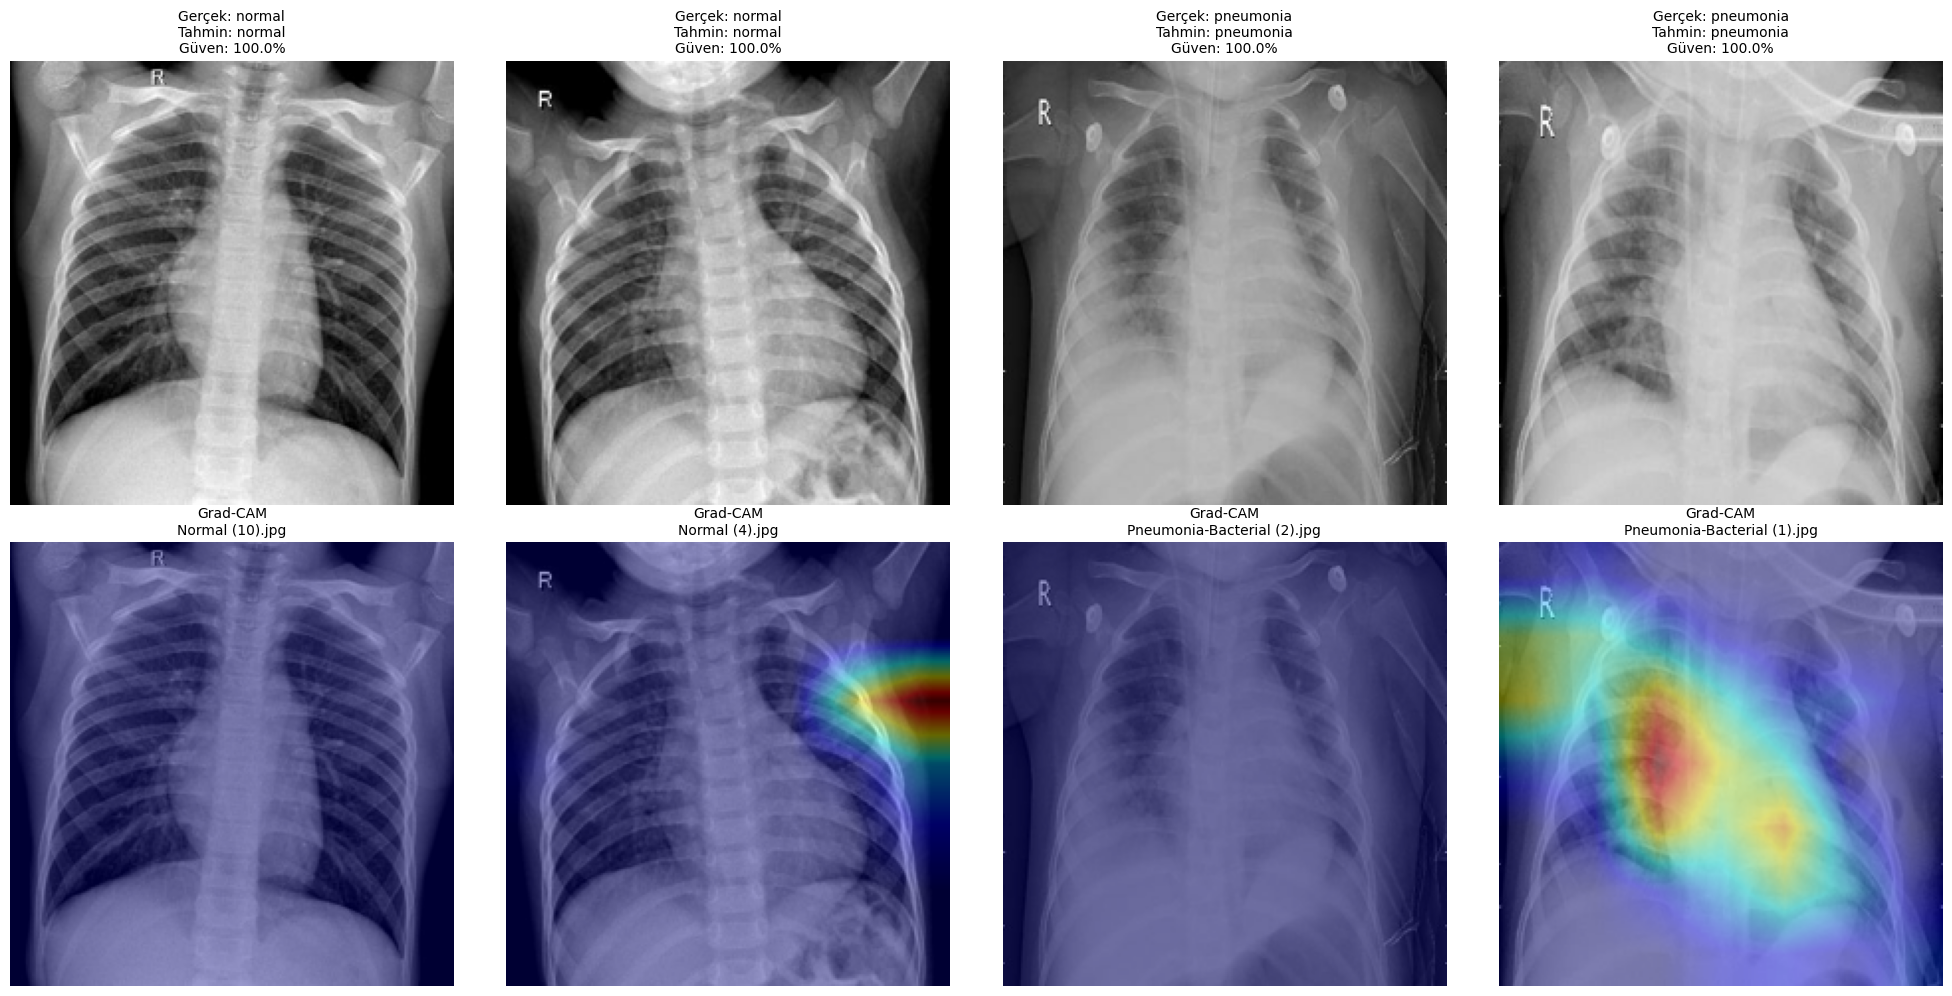

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image
from grad_cam import make_gradcam_heatmap, generate_gradcam_image, get_img_array

# Sınıf isimlerini ve indekslerini tanımla
class_names = ['normal', 'pneumonia']  # İkili sınıflandırma için
class_indices = {'normal': 0, 'pneumonia': 1}

def get_random_samples(data_dir, num_samples=2):
    """Her sınıftan belirtilen sayıda rastgele örnek seç."""
    samples = []
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if not image_files:
            continue
        selected_images = random.sample(image_files, num_samples)
        for img in selected_images:
            full_path = os.path.join(class_dir, img)
            samples.append((full_path, class_indices[class_name]))
    return samples

def predict_and_visualize_with_gradcam(samples, model_path):
    """Görselleri tahmin et, Grad-CAM uygula ve yan yana göster."""
    model = load_model(model_path)
    last_conv_layer_name = 'conv5_block3_out'  # ResNet50 için son konvolüsyon katmanı
    
    plt.figure(figsize=(20, 10))
    for i, (img_path, true_class) in enumerate(samples):
        try:
            # Orijinal görüntü işleme
            img = Image.open(img_path).convert("RGB")
            img_resized = img.resize((224, 224))
            img_array = np.array(img_resized) / 255.0
            img_array_expanded = np.expand_dims(img_array, axis=0)

            # Tahmin
            prediction = model.predict(img_array_expanded)
            predicted_class = int(prediction[0][0] > 0.5)
            confidence = prediction[0][0] * 100 if predicted_class == 1 else (1 - prediction[0][0]) * 100
            predicted_label = class_names[predicted_class]

            # Grad-CAM
            heatmap = make_gradcam_heatmap(img_array_expanded, model, last_conv_layer_name)
            grad_cam_img = generate_gradcam_image(img_path, heatmap)

            # Görselleştirme
            plt.subplot(2, 4, i + 1)
            plt.imshow(img_resized)
            plt.axis("off")
            plt.title(f"Gerçek: {class_names[true_class]}\nTahmin: {predicted_label}\nGüven: {confidence:.1f}%",
                     fontsize=10)

            plt.subplot(2, 4, i + 5)
            plt.imshow(grad_cam_img)
            plt.axis("off")
            plt.title(f"Grad-CAM\n{os.path.basename(img_path)}", fontsize=10)

        except Exception as e:
            print(f"Hata oluştu: {img_path} - {str(e)}")
            continue

    plt.tight_layout()
    plt.show()

# Kullanım
data_dir = "C:\\Users\\Batu\\Documents\\MediAIn\\models\\tamamlandı\\resnet50_1\\test\\"
model_path = "resnet50_best_model_09_0.9954.h5"

samples = get_random_samples(data_dir, num_samples=2)
predict_and_visualize_with_gradcam(samples, model_path)
